In [ ]:
# Import PyDrive and associated libraries
# This only needs to be done once per notebook
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
# This only needs to be done once per notebook
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


file_id = '1SZ-hYkI8UgrfJlgwRWlNLHHHurqUj3Lh' # Check your own ID in GDrive
downloaded = drive.CreateFile({'id': file_id})

# Save file in Colab memory
downloaded.GetContentFile('tweets.csv')  

In [ ]:
pip install contractions emoji textblob

     |████████████████████████████████| 168 kB 28.9 MB/s 
     |████████████████████████████████| 284 kB 47.5 MB/s 
     |████████████████████████████████| 321 kB 77.1 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=c0cb132ef5f9bdc8806a3a9d19c39626c330a5beb35f920ba9bca15faf6adf01
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85440 sha256=94ccbabea0ec1270fbfa8ad2d9ab5d5c257be4bae35257afeedfbbba3b704336
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built emoji pyahocorasick


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, contractions, emoji
from wordcloud import WordCloud
sns.set_style('dark')

In [ ]:
def clean_date(date_obj):
  for x in range(0, len(date_obj)):
    if date_obj[x] == " ":
      break
  date_obj = date_obj[:x]
  return date_obj

def process_tweet(tweet):
  ## Twitter Features
    # replace retweet
  tweet = re.sub('RT\s+', "", tweet )
    # replace user tag
  tweet = re.sub('\B@\w+', "", tweet)
    # replace url
  tweet = re.sub('(http|https):\/\/\S+', "", tweet)
    # replace hashtag
  tweet = re.sub('#+', "", tweet)

  ## Word Features
    # lower case
  tweet = tweet.lower()
    # replace contractions
  tweet = contractions.fix(tweet)
    # replace punctuation repetition
  tweet = re.sub(r'[\?\.\!]+(?=[\?\.\!])', "", tweet)
    # replace word repetition
  tweet = re.sub(r'(.)\1+', r'\1\1', tweet)
    # replace emojis
  tweet = emoji.demojize(tweet)

  return tweet

df = pd.read_csv('tweets.csv',
                 lineterminator='\n')
df = df[df["Language\r"]=="en\r"].drop(['Unnamed: 0', 'Tweet Id', 'Language\r'],axis=1)
df["Datetime"] = df["Datetime"].apply(clean_date)
df["Clean Text"] = df["Text"].apply(process_tweet)
df['Clean Text']= df['Clean Text'].str.replace('[^\w\s]','')


In [ ]:
from textblob import TextBlob

In [ ]:
df['TBScore'] = df['Clean Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
# Set threshold to define neutral sentiment
neutral_thresh = 0.05

# Convert polarity score into sentiment categories
df['Sentiment'] = df['TBScore'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

(array([    0., 10000., 20000., 30000., 40000., 50000.]),
 <a list of 6 Text major ticklabel objects>)

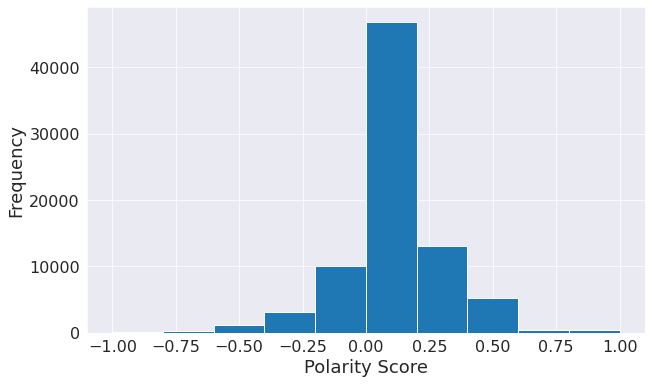

In [ ]:
fig = plt.figure(figsize=(10, 6))
df['TBScore'].hist()
plt.xlabel('Polarity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

**Making wordclouds**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stopwords_to_add = ['covid', 'via', 'v','a','c','c','i','n','e', 'people', 'get','getting','vaccination','vaccination', 'amp', 'vaccine', 'covid19', 'covidvaccine']
stop_words.extend(new_stopwords_to_add)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


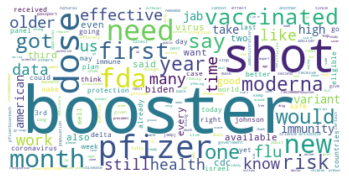

In [ ]:
pos_tweets=df[df["Sentiment"]=="Positive"]
txt=" ".join(tweet for tweet in pos_tweets["Clean Text"])
import re
line = re.sub('vaccine+', "", txt)

wordcloud = WordCloud(collocations = False,
                      background_color = 'white',
                      stopwords=stop_words).generate(line)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

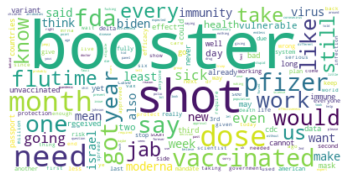

In [ ]:
neg_tweets=df[df["Sentiment"]=="Negative"]
txt=" ".join(tweet.lower() for tweet in neg_tweets["Clean Text"])
line = re.sub('vaccine+', "", txt)
wordcloud = WordCloud(collocations = False,background_color = 'white', stopwords=stop_words).generate(line)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
def get_value_counts(col_name):
    count = pd.DataFrame(df[col_name].value_counts())
    percentage = pd.DataFrame(df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    return value_counts_df

In [ ]:
tb_sentiment_df = get_value_counts('Sentiment')
tb_sentiment_df

,sentiment,counts,percentage
0,Negative,11960,14.81
1,Neutral,30651,37.95
2,Positive,38148,47.24


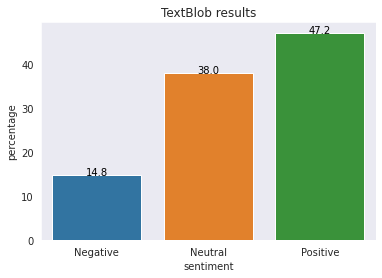

In [ ]:
ax = sns.barplot(x="sentiment", y="percentage", data=tb_sentiment_df)
ax.set_title('TextBlob results')

for index, row in tb_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

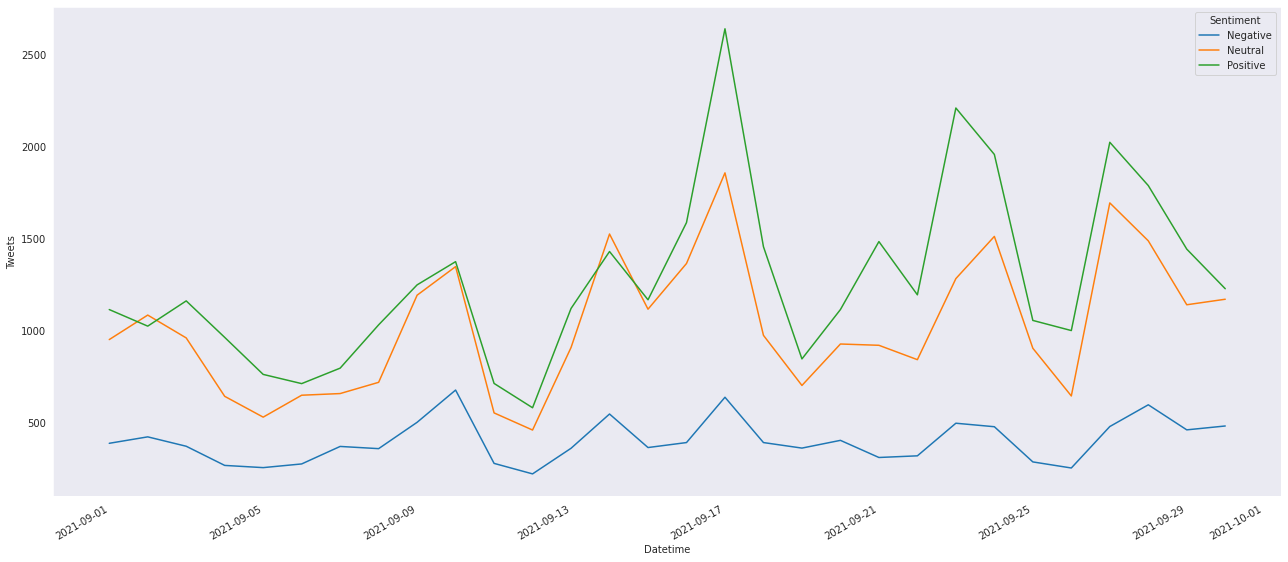

In [ ]:
# Plotting timeseries plot
df["Datetime"] = pd.to_datetime(df.Datetime) 
timeline = df.resample('D', on='Datetime')["Sentiment"].value_counts().unstack(1)
timeline.reset_index(inplace=True)
timeline = timeline.melt("Datetime", var_name='Sentiment',  value_name='Tweets')

plt.figure(figsize=(22,10))
ax = sns.lineplot(x="Datetime", y="Tweets", hue="Sentiment", data=timeline)
ax.figure.autofmt_xdate()

In [ ]:
pd.set_option('display.max_colwidth', 400)
df.sort_values(by='TBScore', ascending=True)[['Text', 'TBScore', 'Username']].reset_index(drop=True).head(n=10)

,Text,TBScore,Username
0,‘We Sent a Terrible Message’: Scientists Say Biden Jumped the Gun With Vaccine Booster Plan #NewsBreak https://t.co/WM98ZauCv4,-1.0,Evertbeetho
1,"#COVID19 \n\nUS President Joe Biden, who received booster shots of the vaccine, says unvaccinated citizens are causing an ‘awful lot of damage for the rest of the country’ \n\nhttps://t.co/RCbrwKnQKc",-1.0,scroll_in
2,"Between vaccine passports, apptracing, booster shots, police with masks and helmets and censoring of information I’m getting real sick of it all. Borderline pissed off! \n\nThe people will rise together and those anonymous cops will cry for forgiveness. And we should forgive! https://t.co/2wAZcq4GMh",-1.0,DAOFUQ
3,@cvspharmacy your phone agents are giving out incorrect information about COVID vaccine booster doses. I tried to speak with a supervisor snd 3 separate agents cut the call. Horrible customer service,-1.0,anmifis
4,I got whooping cough 9 yrs ago. Had had childhood vax but no booster.\nIt was terrifying at times.\nI have permanent damage to the muscles around my vocal cords.\nGet your vaccines. All of them. Boosters included. 🙏 https://t.co/easfDYrwHx,-1.0,whickity01
5,"https://t.co/M5aJBcIRHR Now they are requiring a COVID vaccine booster every 5 months! Are the pharmaceutical companies, Fauci, FDA &amp; the Biden administration hoping fearmongering &amp; mandates will booster their already outrageous income levels?",-1.0,ZechiniVicki
6,WHO calls for halt to booster jabs amid 'shocking vaccine inequity' \n\n#Covid_19 \nhttps://t.co/GP0D0XhO1f,-1.0,PressTV
7,"@POTUS So you can inject us, booster every year till we die from these poison vaccines! You are an evil man!",-1.0,Douglas00498697
8,"Hell no vaccine..no booster shot..no masks👍🏻\nAfter a year or two goes by, what terrible side effects are going to show up in humans that took the vaccine ? Heart problems, birth defects, kidney problems, lung problems. Kids with lung problems from wearing masks 12 hrs. a day🤔",-1.0,tom70006983
9,"@ZubyMusic They would call that a disingenuous assumption. Because with a booster shot and the vaccine, you would protect the people from going insane. So they're calling it for Covid. At this point we need to cure mass hysteria.",-1.0,Stephanospi


In [ ]:
df.sort_values(by='TBScore', ascending=False)[['Text', 'TBScore', 'Username']].reset_index(drop=True).head(n=10)


,Text,TBScore,Username
0,"NIH director says Israeli Covid booster data is 'impressive,' shows tenfold reduction in infection: The National Institutes of Health director called Israel's data on Covid vaccine booster shots ""impressive,"" saying it shows a tenfold reduction in… https://t.co/555vH1weHO https://t.co/PkrwIuGqBo",1.0,stockleaksnews
1,Quite impressive indeed... \n\nProtection of BNT162b2 Vaccine Booster against Covid-19 in Israel | NEJM https://t.co/B8RwhoX03z,1.0,DanielAletaha
2,"This quote on booster vaccines perfectly encapsulates the maddening pit HK is in with regards to Covid: ""If we know when the border will reopen, perhaps we will need to start doing work two months before the reopening"" https://t.co/kzF41U2TwZ",1.0,Birdyword
3,"@jreddlovette @TeyaSophia I entered, but it was stressful so I just did the best I could!",1.0,FKGaillard
4,@pogokero @RealMattCouch If it’s the best why a booster? Why are people who have the vaccine still dying from covid?,1.0,burkett_chase
5,"@MichealMartinTD Yet you still won't remove restrictons come 22nd October! 2 weeks before this date, you'll announce that the Wu &amp; Lambda variants are a cause of concern and might not work against the vaccine, best to air on the side of caution and wait untl the booster is rolled out to everyone",1.0,james99570263
6,Tucker said it best about the vaccine &amp; booster shots https://t.co/z2L2f7wQHH,1.0,PinniesH
7,#VaccineBooster shot may be our best hope for removing #CreepyJoe https://t.co/jOReSBKUb0,1.0,Torpor24918710
8,"@MartyMakary Hello I wanted to share my data:\n 1 At 15 days after the Janssen vaccination\n 2 to 30 days after the Janssen vaccine\n 3 at 45 days after the Janssen vaccine\n 4 2 months after the Janssen vaccine I got a booster from Pfizer. \n\nbest regards from Costa Rica, Pura Vida!! https://t.co/TlZLUT3rlz",1.0,cristianjbcr_
9,Concerned about Delta? Best practices below. \n\nVaccine + n95 mask. Booster when recommended. https://t.co/Hr7HHsDwJ5,1.0,mbrockenbrough


In [ ]:
# VADER ANALYSIS
import nltk
nltk.download('vader_lexicon') # Download the VADER lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Obtaining NLTK scores
df['VScore'] = df['Clean Text'].apply(lambda x: sia.polarity_scores(x))

# Obtaining NLTK compound score
df['VComp'] = df['VScore'].apply(lambda score_dict: score_dict['compound'])

# Set threshold to define neutral sentiment
neutral_thresh = 0.05

# Categorize scores into the sentiments of positive, neutral or negative
df['Sentiment'] = df['VComp'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 <a list of 7 Text major ticklabel objects>)

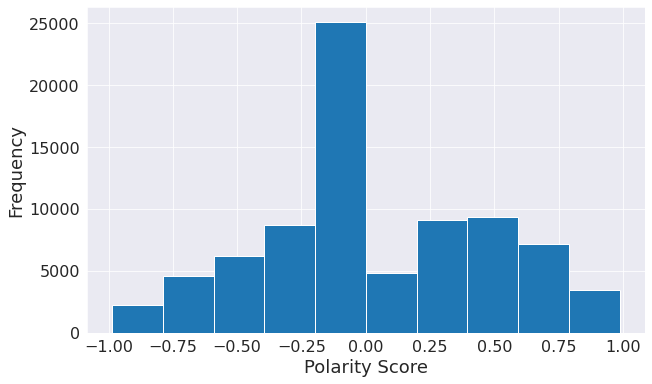

In [ ]:
fig = plt.figure(figsize=(10, 6))
df['VComp'].hist()
plt.xlabel('Polarity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

**Making wordclouds**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stopwords_to_add = ['covid', 'via', 'v','a','c','c','i','n','e', 'people', 'get','getting','vaccination','vaccination', 'amp', 'vaccine', 'covid19', 'covidvaccine']
stop_words.extend(new_stopwords_to_add)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


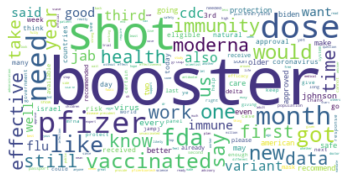

In [ ]:
pos_tweets=df[df["Sentiment"]=="Positive"]
txt=" ".join(tweet for tweet in pos_tweets["Clean Text"])
import re
line = re.sub('vaccine+', "", txt)

wordcloud = WordCloud(collocations = False,
                      background_color = 'white',
                      stopwords=stop_words).generate(line)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

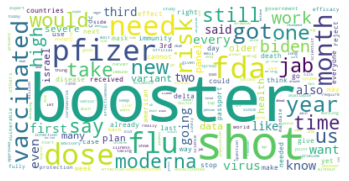

In [ ]:
neg_tweets=df[df["Sentiment"]=="Negative"]
txt=" ".join(tweet.lower() for tweet in neg_tweets["Clean Text"])
line = re.sub('vaccine+', "", txt)
wordcloud = WordCloud(collocations = False,background_color = 'white', stopwords=stop_words).generate(line)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
def get_value_counts(col_name):
    count = pd.DataFrame(df[col_name].value_counts())
    percentage = pd.DataFrame(df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    return value_counts_df
tb_sentiment_df = get_value_counts('Sentiment')
tb_sentiment_df

,sentiment,counts,percentage
0,Negative,25208,31.21
1,Neutral,22431,27.78
2,Positive,33120,41.01


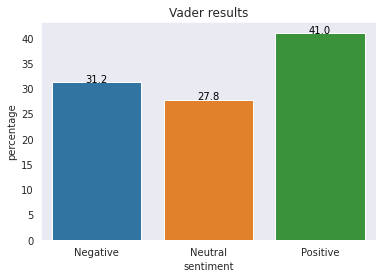

In [ ]:
ax = sns.barplot(x="sentiment", y="percentage", data=tb_sentiment_df)
ax.set_title('Vader results')

for index, row in tb_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

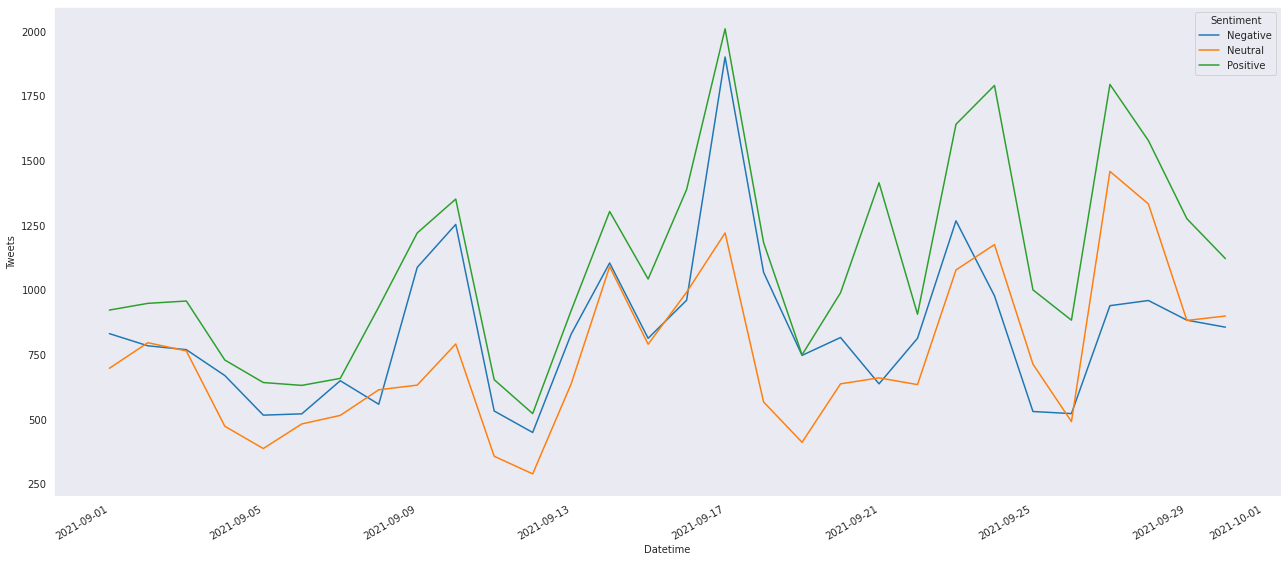

In [ ]:
df["Datetime"] = pd.to_datetime(df.Datetime) 
timeline = df.resample('D', on='Datetime')["Sentiment"].value_counts().unstack(1)
timeline.reset_index(inplace=True)
timeline = timeline.melt("Datetime", var_name='Sentiment',  value_name='Tweets')

plt.figure(figsize=(22,10))
ax = sns.lineplot(x="Datetime", y="Tweets", hue="Sentiment", data=timeline)
ax.figure.autofmt_xdate()

In [ ]:
pd.set_option('display.max_colwidth', 400)
df.sort_values(by='VComp', ascending=True)[['Text', 'VComp', 'Username']].reset_index(drop=True).head(n=10)

,Text,VComp,Username
0,"@SBaysden They say three booster shoots per year, but really what it means is ""as we all knew, there is no ONE vaccine for life for coronavirus (ex: flu), and we're so bad we need 3 shots for each yearly vaccine""\nSo, basically, it's a very bad flu vaccine (more than 1 shot is bad dev)",-0.9853,Max_from_France
1,It will never be enough.\n\nThis is how Control Through Fear works.\n\nFear the Communists for 50 years.\nRussia Russia Russia! Every year.\n\nFear the jihadists for 30 years.\nWar on terror! War on terror! Every year.\n\nFear the invisible virus.\nVaccine! Booster! Flu season! Every year. https://t.co/ltk1kce5am,-0.9834,valithegod
2,"“but the vaccine has really bad side effects!” yah no shit all vaccines do i had muscle aches and hot and cold chills when i had to get my meningitis and tdap booster at 18. sorry if you’re a little bitch for being scared of a sore arm, a headache, and drowsiness for 24 hours",-0.9829,goldennolyn
3,@Sandowler @LozzaFox But my 'shit' is backed with evidence. The vaccine killed my uncle and left my mum with heart failure. There is no way you will get my kids to go anywhere near it. My mum has been told by her heart specialist that if she gets the booster she will be dead. Plain and simple.,-0.9803,YouDontKnow131
4,"@orp2150 @VABVOX Just had it done after work yesterday. My arm is sore, but no other reactions to the booster or the flu shot. My first two covid shots had no reaction. My arm was never sore. I believe my arm is sore now due to the flu shot. It always is sore whenever I get the flu vaccine.",-0.9783,pvalt42
5,It's just my opinion but... it's fuckin' nuts that people are getting the Covid vaccine BOOSTER and some dumb fuck Americans refuse to even get the first dose. They try some of the most ignorant fucking shit in a search of alternative remedies.,-0.9771,runsamuck2
6,"And let's unleash a bio-weapon called COVID-19 and various mutations of it to kill off those who manage to survive our two vaccines and endless booster shots, along with sterilization, abortion, suicide and murder, war, terrorism, etc....",-0.9761,KirkCoon9698
7,"I am afraid of needles, the last thing I’d ever do is volunteer to get a shot. But I put my fear away, and got the shot, the vaccine, and it was absolutely nothing to fear. It was done in no time, no pain, no ill effects. If required I’ll happily get the booster. Worry not. https://t.co/VcKpHhDTdY",-0.9753,JamesHu18332770
8,"covid sufferers are being denied booster shots. This is all wrong. Why are we being punished because of some selfish, stupid #antivaxxers? Why are we long covid sufferers who fought with our lives when #vaccines were not yet available,",-0.9738,black_visions
9,"@ZarinTaylor @SenRonJohnson 15,000 Americans dead from the vaccine. I’d call that murder. 660,000 seriously injured. I’d call that a failed vaccine. How many boosters you going to take? They are planning at least 5.Every booster weakens your immunity more and more till your dead. Go ahead follow Biden.",-0.9729,dianesu44580009


In [ ]:
df.sort_values(by='VComp', ascending=False)[['Text', 'VComp', 'Username']].reset_index(drop=True).head(n=10)

,Text,VComp,Username
0,Learning more\nTeaching more\nCaring more\nHelping more\nLoving more\n\nGreater benevolence &amp; kindness\nMore understanding &amp; patient calmness\nKindness &amp; extroverted social engagement\nWearing a filtering mask for public safety\nGetting a booster vaccine shot #3 total \nSharing Ideas more!,0.9865,CosmicInglewood
1,@POTUS I GOT BOTH THE PFIZER VACCINES &amp; I FEEL GREAT I'M JUST WAITING FOR MY BOOSTER SHOT THANKS FOR MAKING OUR WORLD A BETTER SAFER PLACE &amp; THANKS FOR HELPING THE PEOPLE WHO ARE STRUGGLING LOVE YOU PRESIDENT BIDEN LOVE YOU TO THE MOON &amp; BACK 💖 STAY SAFE &amp; GOOD LUCK 🙏 🙏,0.9851,LamontT91982184
2,"@TMDTH1 @jodi_geczi @ToddShadley Fantastic read, it literally confirms the study that I shared and confirms that the vaccine works but that it just wares of and the third booster is having great success in folks over 60. The study I shared has multiple parts, I only shared two of them. Thanks for sharing.",0.9825,sharpcutco
3,"@VanessMar You will be fine. U need the vaccine, not only to protect yourself but also to protect ur loved ones \nI got mine &amp; I'm fine. I'm ready for the booster soon.\nThanks for not believing the lies. U are helping the world get back to normal. Encourage others to do the same. God bless.",0.9822,WheelinGreg
4,"Got my Pfizer booster today. So thankful to have survived the pandemic. So thankful the vaccine exists &amp; is accessible to me. Wish it were the same for everyone. I am blessed, grateful and humbled. #Pfizer #BoosterShots #CovidVaccine #blessed",0.9804,SnapdragonGo
5,"@GrahamAllen_1 Hi Graham, I chose to get the vaccine and will prob chose the booster as well but respect your right to choose what whatever you and your doctor think best. Interesting studies on natural immunity coming out of Israel. According to Joe, weekly testing will be option for job Best",0.9779,emmak_anne
6,"@MABlumenfeld It’s pretty clear the vaccine effectiveness wears down over time. Pfizer may be a self interested party, but it says the booster is helpful and has a benefit. Would love to see the data behind that, but my gut reaction is to trust Pfizer.",0.9765,SteveMatthews12
7,"@michaeljknowles Isnt it the other way around? The vaccines are so effective that most people dont need a booster, but for those who *might* benefit from one (older/weaker immune system), it is safe enough that we can be comfortable giving them one. (Safety concerns seem to be mostly ages &lt;25)",0.9761,TwiceFriedEthos
8,Thank you Namrata for your kind words! We're delighted you got your booster and it's great to highlight the hard work each team across all health and care services do to help people like yourself get their vaccine; so thank you for the reminder! 😀🙏👍 https://t.co/b49DRqyXy8,0.9756,FrimleyHC
9,Pfizer seeks FDA approval for vaccine booster dose – Mind Body Love\nhttps://t.co/dIovzLQUrg\n#modeling #model #photography #fashion #photoshoot #photooftheday #instagram #instagood #love #style #portrait #follow #photo #photographer #like #beauty #picoftheday #beautiful #art #like,0.9756,JInfo4us


In [ ]:
pip install nrclex

     |████████████████████████████████| 396 kB 28.1 MB/s 
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43328 sha256=713ae1d80ee4171960adb2bcfe9e8d6650dda44d542b15f7bbcf921333f23341
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built nrclex


In [ ]:
nltk.download('punkt')
from nrclex import NRCLex
#nrclex outputs a score for all 9 emotions, but we only want the emotion with the highest score (usually the first output)
emotion = []
for text in df["Clean Text"]:
    emotions = NRCLex(text)
    emotion.append(emotions.top_emotions[0][0])
df['Emotion'] = emotion


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df["Emotion"].value_counts()

positive        48031
fear            15194
negative         7055
trust            5888
anger            2105
anticipation     1220
surprise          867
sadness           386
disgust            11
joy                 2
Name: Emotion, dtype: int64

In [ ]:
def get_value_counts_emotion(col_name):
    count = pd.DataFrame(df[col_name].value_counts())
    percentage = pd.DataFrame(df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['emotion', 'counts', 'percentage']
    value_counts_df.sort_values('emotion', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    return value_counts_df
emotion_df = get_value_counts_emotion('Emotion').sort_values(by='counts',ascending=False).reset_index()
del emotion_df["index"]

emotion_df

,emotion,counts,percentage
0,positive,48031,59.47
1,fear,15194,18.81
2,negative,7055,8.74
3,trust,5888,7.29
4,anger,2105,2.61
5,anticipation,1220,1.51
6,surprise,867,1.07
7,sadness,386,0.48
8,disgust,11,0.01
9,joy,2,0.00


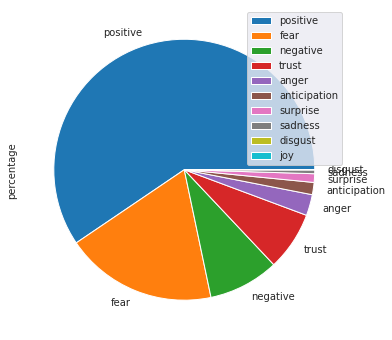

In [ ]:
plot = emotion_df.set_index('emotion').plot.pie(y='percentage', figsize=(10, 6))

Text(0.5, 1.0, 'Emotion Analysis- December Data')

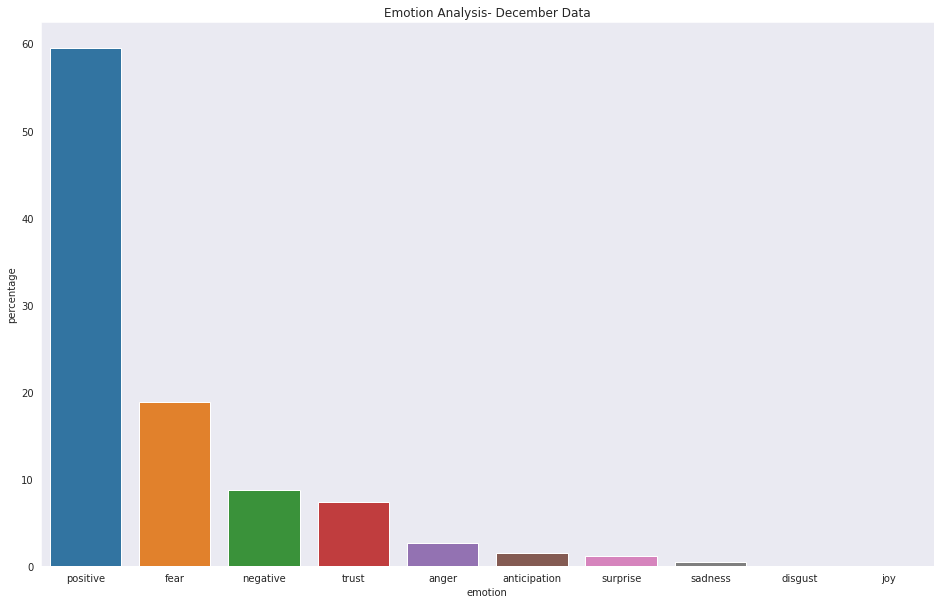

In [ ]:
# Plotting percentage of sentiments
plt.figure(figsize=(16,10))
ax = sns.barplot(x="emotion", y="percentage", data=emotion_df)
ax.set_title('Emotion Analysis- Vaccine Booster Data')
